# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [2]:
# Update the PATH to include the user installation directory. 
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

# Restart the Kernel before you move on to the next step.

#### Important: Restart the Kernel before you move on to the next step.

In [3]:
# Install requirements
!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


## Imports

In [4]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix
from typing import List, Optional, Tuple, Union

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [5]:
#  Define transforms for training and testing
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# For visualization, we'll use transforms without normalization
viz_transform = transforms.Compose([
    transforms.ToTensor()
])

# Create training set and define training dataloader
train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=train_transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True,
    num_workers=2
)

# Create test set and define test dataloader
test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=train_transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=False,
    num_workers=2
)

# Visualization dataset (without normalization)
viz_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=False, 
    transform=viz_transform
)

viz_loader = torch.utils.data.DataLoader(
    viz_dataset, 
    batch_size=64, 
    shuffle=True
)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training samples: 60000
Test samples: 10000


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

1. ToTensor(): 
   - That will converts PIL images to PyTorch tensors ans scales pixel values        from        [0,255] to [0,1]

2. Normalize((0.1307,), (0.3081,)):
   - Uses MNIST dataset statistics (mean=0.1307, std=0.3081)
   - Normalizes data to have zero mean
   - Improves training stability and convergence speed
   - Helps prevent vanishing/exploding gradients

3. No flattening, in transforms:
   - We will handle flattening in the neural network architecture
   - Maintains spatial structure until needed
   - More flexible for potential CNN architectures

4. Batch size of 64:
   - Good balance between memery usage and gradient stability
   - Allows for efficient GPU utilization


**DOUBLE CLICK THIS CELL TO MODIFY**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [6]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##        
def show5(img_loader):
    dataiter = iter(img_loader)
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    
    fig, axes = plt.subplots(1, 5, figsize=(12, 3))
    for i in range(5):
        print(f"Label: {int(labels[i].detach())}")
        image = images[i].numpy()
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {int(labels[i])}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

Dataset Exploration:
Image shape: torch.Size([1, 28, 28])
Number of classes: 10
Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

Sample images from the dataset:
Label: 1
Label: 2
Label: 8
Label: 5
Label: 2


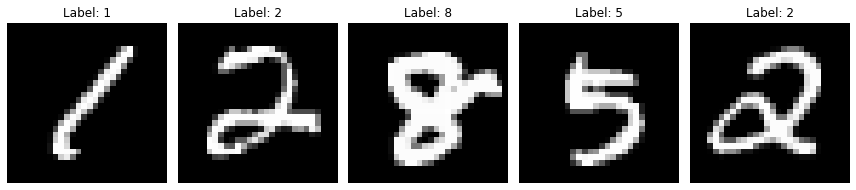

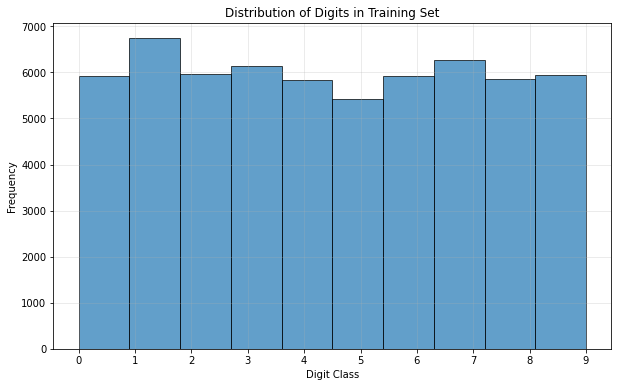

In [7]:
# Explore data dimensions and properties
print("Dataset Exploration:")
print(f"Image shape: {train_dataset[0][0].shape}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")

# Show sample images
print("\nSample images from the dataset:")
show5(viz_loader)


# Class distribution analysis
train_targets = train_dataset.targets.numpy()
plt.figure(figsize=(10, 6))
plt.hist(train_targets, bins=10, alpha=0.7, edgecolor='black')
plt.xlabel('Digit Class')
plt.ylabel('Frequency')
plt.title('Distribution of Digits in Training Set')
plt.xticks(range(10))
plt.grid(True, alpha=0.3)
plt.show()

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

### NEURAL NETWORK ARCHITECTURE

In [8]:
class MNISTClassifier(nn.Module):
    """
    MNIST Classifier with multiple hidden layers and dropout regularization.
    
    Architecture:
    - Input: 28x28 grayscale images (784 features after flattening)
    - Hidden layers: 512 -> 256 -> 128 neurons with ReLU activation
    - Dropout regularization to prevent overfitting
    - Output: 10 classes with softmax activation
    """
    
    def __init__(self, input_size=784, hidden_sizes=[512, 256, 128], num_classes=10, dropout_rate=0.3):
        super(MNISTClassifier, self).__init__()
        
        # Flatten layer for converting 2D images to 1D
        self.flatten = nn.Flatten()
        
        # First hidden layer
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Second hidden layer
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Third hidden layer
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Output layer
        self.fc4 = nn.Linear(hidden_sizes[2], num_classes)
        
        # Initialize weights using Xavier initialization
        self._initialize_weights()
        
    def _initialize_weights(self):
        """Initialize weights using Xavier initialization for better convergence."""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)
                
    def forward(self, x):
        # Flatten the input
        x = self.flatten(x)
        
        # First hidden layer with ReLU and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        
        # Second hidden layer with ReLU and dropout
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        
        # Third hidden layer with ReLU and dropout
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        
        # Output layer with softmax (applied in training loop)
        x = self.fc4(x)
        
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

### MODEL INSTANTIATION AND CONFIGURATION

In [9]:
# Instantiate the model
base_model = MNISTClassifier().to(device)

# Loss function: CrossEntropyLoss is ideal for multi-class classification
# It combines LogSoftmax and NLLLoss, providing numerical stability
base_criterion = nn.CrossEntropyLoss()

# Optimizer: Adam with learning rate scheduling
base_optimizer = optim.Adam(base_model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler for better convergence
base_scheduler = optim.lr_scheduler.StepLR(base_optimizer, step_size=10, gamma=0.7)

print(f"Model architecture:\n{base_model}")
print(f"Base Model Parameters: {sum(p.numel() for p in base_model.parameters()):,}")

Model architecture:
MNISTClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)
Base Model Parameters: 567,434


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

### TRAINING FUNCTION

In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    """
    Training function with validation at each epoch for overfitting detection.
    """
    
    model.train()
    
    # Track metrics for both training and validation
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    print("Starting training with validation...")
    print("=" * 70)
    
    for epoch in range(num_epochs):
        # ==========================================
        # TRAINING PHASE
        # ==========================================
        
        model.train() 
        
        running_train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        # Progress bar for each epoch
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        
        for batch_idx, (data, targets) in enumerate(train_pbar):
            # Move data to device
            data, targets = data.to(device), targets.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()
            
            # Update progress bar
            if batch_idx % 100 == 0:
                current_acc = 100. * train_correct / train_total
                train_pbar.set_postfix({
                    'Loss': f'{running_train_loss/(batch_idx+1):.4f}',
                    'Acc': f'{current_acc:.2f}%'
                })
        
        # Calculate training metrics for this epoch
        epoch_train_loss = running_train_loss / len(train_loader)
        epoch_train_acc = 100. * train_correct / train_total
        
        # ==========================================
        # VALIDATION PHASE
        # ==========================================
        model.eval()  # Set to evaluation mode
        running_val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_batches_processed = 0  
        
        with torch.no_grad():  # No gradients needed for validation
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]  ')
            
            for data, targets in val_pbar:
                data, targets = data.to(device), targets.to(device)
                
                # Forward pass only
                outputs = model(data)
                loss = criterion(outputs, targets)
                
                # Statistics
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
                val_batches_processed += 1
                
                # Update progress bar
                current_val_acc = 100. * val_correct / val_total
                val_pbar.set_postfix({
                    'Loss': f'{running_val_loss/val_batches_processed:.4f}',
                    'Acc': f'{current_val_acc:.2f}%'
                })
                
        # Calculate validation metrics for this epoch
        epoch_val_loss = running_val_loss / len(val_loader)
        epoch_val_acc = 100. * val_correct / val_total
        
        # Store metrics
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)
        
        # Step the scheduler
        if scheduler:
            scheduler.step()
        
        # Print epoch summary
        print(f'Epoch [{epoch+1:2d}/{num_epochs}] | '
              f'Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:6.2f}% | '
              f'Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:6.2f}%')
    
    print("=" * 70)
    print("Training completed!")
    
    # Print final summary
    print(f"\n📊 Final Results:")
    print(f"   Training   - Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"   Validation - Loss: {val_losses[-1]:.4f}, Accuracy: {val_accuracies[-1]:.2f}%")
    
    return train_losses, train_accuracies, val_losses, val_accuracies

### PLOT TRAINING METRICS FUNCTION

In [11]:
def plot_training_validation_curves(train_losses, train_accuracies, val_losses, val_accuracies,
                                   model_name="Model", figsize=(15, 5)):
    """
    Plot training and validation curves to detect overfitting.
    """
        
    # Clear any existing plots to prevent duplicates
    plt.close('all')
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    epochs = range(1, len(train_losses) + 1)
    
    # ===============================
    # LOSS PLOT (Training vs Validation)
    # ===============================
    ax1.plot(epochs, train_losses, 'b-', linewidth=2.5, label='Training Loss', marker='o', markersize=4)
    ax1.plot(epochs, val_losses, 'r-', linewidth=2.5, label='Validation Loss', marker='s', markersize=4)
    
    ax1.set_title(f'{model_name} - Training & Validation Loss', fontsize=14, fontweight='bold', pad=15)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(fontsize=11, loc='best')
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_xlim(1, len(train_losses))
    
    # Add annotations for minimum losses
    min_train_loss = min(train_losses)
    min_train_epoch = train_losses.index(min_train_loss) + 1
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss) + 1
    
    ax1.annotate(f'Min Train: {min_train_loss:.4f}', 
                xy=(min_train_epoch, min_train_loss), 
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='blue', alpha=0.3),
                fontsize=9)
    
    ax1.annotate(f'Min Val: {min_val_loss:.4f}', 
                xy=(min_val_epoch, min_val_loss), 
                xytext=(10, -15), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.3),
                fontsize=9)
    
    # ===============================
    # ACCURACY PLOT (Training vs Validation)
    # ===============================
    ax2.plot(epochs, train_accuracies, 'g-', linewidth=2.5, label='Training Accuracy', marker='o', markersize=4)
    ax2.plot(epochs, val_accuracies, 'orange', linewidth=2.5, label='Validation Accuracy', marker='s', markersize=4)
    
    ax2.set_title(f'{model_name} - Training & Validation Accuracy', fontsize=14, fontweight='bold', pad=15)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.legend(fontsize=11, loc='best')
    
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_xlim(1, len(train_accuracies))
    ax2.set_ylim(0, 100)
    
    # Add annotations for maximum accuracies
    max_train_acc = max(train_accuracies)
    max_train_epoch = train_accuracies.index(max_train_acc) + 1
    max_val_acc = max(val_accuracies)
    max_val_epoch = val_accuracies.index(max_val_acc) + 1
    
    ax2.annotate(f'Max Train: {max_train_acc:.2f}%', 
                xy=(max_train_epoch, max_train_acc), 
                xytext=(10, -15), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='green', alpha=0.3),
                fontsize=9)
    
    ax2.annotate(f'Max Val: {max_val_acc:.2f}%', 
                xy=(max_val_epoch, max_val_acc), 
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='orange', alpha=0.3),
                fontsize=9)
    
    plt.tight_layout(pad=3.0) 
    
    plt.show()

### PLOT CONFUSION MATRIX FUNCTION

In [12]:
def plot_confusion_matrix(y_true: Union[List, np.ndarray], 
                         y_pred: Union[List, np.ndarray],
                         class_names: Optional[List[str]] = None,
                         model_name: str = "Model",
                         normalize: bool = False,
                         figsize: Tuple[int, int] = (12, 10),  
                         cmap: str = 'Blues') -> plt.Figure:

    
    # Clear any existing plots
    plt.close('all')
    
    # Convert to numpy arrays if needed
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalize if requested
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title_suffix = ' (Normalized)'
    else:
        fmt = 'd'
        title_suffix = ''
    
    # Set up class names
    if class_names is None:
        class_names = [str(i) for i in range(cm.shape[0])]
    
    # Create figure with extra space for text
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create heatmap
    im = sns.heatmap(cm, 
                     annot=True, 
                     fmt=fmt, 
                     cmap=cmap,
                     xticklabels=class_names,
                     yticklabels=class_names,
                     cbar_kws={'label': 'Normalized Count' if normalize else 'Count'},
                     ax=ax,
                     square=True,
                     linewidths=0.5,
                     cbar=True)
    
    # Customize plot
    ax.set_title(f'{model_name} - Confusion Matrix{title_suffix}', 
                fontsize=16, fontweight='bold', pad=25)  
    ax.set_xlabel('Predicted Label', fontsize=14, labelpad=15)
    ax.set_ylabel('True Label', fontsize=14, labelpad=15)
    
    # Rotate labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right")
    
    # Calculate accuracy and statistics
    total_samples = np.sum(cm)
    correct_predictions = np.trace(cm)
    accuracy = (correct_predictions / total_samples) * 100
    
    # Overall accuracy - top left, outside plot area
    accuracy_text = f'Overall Accuracy: {accuracy:.2f}%'
    fig.text(0.02, 0.95, accuracy_text, fontsize=14, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8, edgecolor='navy'),
             verticalalignment='top')
    
    # Sample count - top right, outside plot area
    if not normalize:
        count_text = f'Correct: {correct_predictions:,}/{total_samples:,}'
        fig.text(0.98, 0.95, count_text, fontsize=12,
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8, edgecolor='darkgreen'),
                 verticalalignment='top', horizontalalignment='right')
    
    # ===============================
    # PERFORMANCE BREAKDOWN
    # ===============================
    
    # Calculate per-class accuracy for additional insights
    per_class_accuracy = []
    for i in range(cm.shape[0]):
        if cm[i].sum() > 0:  
            class_acc = cm[i, i] / cm[i].sum() * 100
            per_class_accuracy.append(class_acc)
        else:
            per_class_accuracy.append(0.0)
    
    # Find best and worst performing classes
    best_class = np.argmax(per_class_accuracy)
    worst_class = np.argmin(per_class_accuracy)
    
    # Add performance insights at the bottom
    insights_text = (f'Best: Digit {best_class} ({per_class_accuracy[best_class]:.1f}%) | '
                    f'Worst: Digit {worst_class} ({per_class_accuracy[worst_class]:.1f}%) | '
                    f'Avg: {np.mean(per_class_accuracy):.1f}%')
    
    fig.text(0.5, 0.02, insights_text, fontsize=11,
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8, edgecolor='orange'),
             horizontalalignment='center', verticalalignment='bottom')
    
    # Adjust layout to accommodate external text
    plt.subplots_adjust(top=0.85, bottom=0.15, left=0.1, right=0.9)
    
    plt.show()

### PLOT MODEL COMPARISON FUNCTION

In [44]:
def plot_model_comparison(models_data: dict,
                         metric: str = 'accuracy',
                         figsize: Tuple[int, int] = (12, 6)):  
    
    model_names = list(models_data.keys())
    values = [models_data[name][metric] for name in model_names]
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Color scheme
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
    bar_colors = colors[:len(model_names)]
    
    # Create bars
    bars = ax.bar(model_names, values, color=bar_colors, alpha=0.8, edgecolor='black', linewidth=1)
    
    # Customize plot
    metric_labels = {
        'accuracy': 'Accuracy (%)',
        'loss': 'Loss',
        'params': 'Parameters (Millions)'
    }
    
    ax.set_title(f'Model Comparison - {metric_labels.get(metric, metric.title())}', 
                fontsize=16, fontweight='bold', pad=20)
    ax.set_ylabel(metric_labels.get(metric, metric.title()), fontsize=14)
    ax.set_xlabel('Models', fontsize=14)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        if metric == 'params':
            label = f'{value/1000000:.1f}M'
        elif metric == 'accuracy':
            label = f'{value:.2f}%'
        else:
            label = f'{value:.3f}'
            
        ax.text(bar.get_x() + bar.get_width()/2., height + max(values)*0.01,
                label, ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    # Styling
    ax.grid(True, alpha=0.3, axis='y')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Adjust y-axis
    if metric == 'accuracy':
        ax.set_ylim(0, 100)
    else:
        ax.set_ylim(0, max(values) * 1.1)
    
    plt.xticks(rotation=15, ha='right')
    plt.tight_layout()
    plt.show()

### BASE MODEL TRAINING

In [15]:
# Train base model with validation
base_train_losses, base_train_accs, base_val_losses, base_val_accs = train_model(
    base_model, train_loader, test_loader, base_criterion, base_optimizer, base_scheduler, num_epochs=10
)

Starting training with validation...


Epoch 1/10 [Val]  : 100%|██████████| 157/157 [00:04<00:00, 32.47it/s, Loss=0.1353, Acc=95.78%]


Epoch [ 1/10] | Train Loss: 0.3488 | Train Acc:  89.35% | Val Loss: 0.1353 | Val Acc:  95.78%


Epoch 2/10 [Val]  : 100%|██████████| 157/157 [00:03<00:00, 40.23it/s, Loss=0.1122, Acc=96.88%]


Epoch [ 2/10] | Train Loss: 0.1775 | Train Acc:  94.85% | Val Loss: 0.1122 | Val Acc:  96.88%


Epoch 3/10 [Val]  : 100%|██████████| 157/157 [00:04<00:00, 38.20it/s, Loss=0.1026, Acc=97.02%]


Epoch [ 3/10] | Train Loss: 0.1376 | Train Acc:  96.01% | Val Loss: 0.1026 | Val Acc:  97.02%


Epoch 4/10 [Val]  : 100%|██████████| 157/157 [00:04<00:00, 36.25it/s, Loss=0.0992, Acc=97.21%]


Epoch [ 4/10] | Train Loss: 0.1233 | Train Acc:  96.31% | Val Loss: 0.0992 | Val Acc:  97.21%


Epoch 5/10 [Val]  : 100%|██████████| 157/157 [00:04<00:00, 38.40it/s, Loss=0.0789, Acc=97.67%]


Epoch [ 5/10] | Train Loss: 0.1096 | Train Acc:  96.85% | Val Loss: 0.0789 | Val Acc:  97.67%


Epoch 6/10 [Val]  : 100%|██████████| 157/157 [00:03<00:00, 41.61it/s, Loss=0.0891, Acc=97.34%]


Epoch [ 6/10] | Train Loss: 0.0973 | Train Acc:  97.10% | Val Loss: 0.0891 | Val Acc:  97.34%


Epoch 7/10 [Val]  : 100%|██████████| 157/157 [00:04<00:00, 37.65it/s, Loss=0.0825, Acc=97.73%]


Epoch [ 7/10] | Train Loss: 0.0920 | Train Acc:  97.38% | Val Loss: 0.0825 | Val Acc:  97.73%


Epoch 8/10 [Val]  : 100%|██████████| 157/157 [00:04<00:00, 36.86it/s, Loss=0.0765, Acc=97.85%]


Epoch [ 8/10] | Train Loss: 0.0862 | Train Acc:  97.41% | Val Loss: 0.0765 | Val Acc:  97.85%


Epoch 9/10 [Val]  : 100%|██████████| 157/157 [00:04<00:00, 35.90it/s, Loss=0.0828, Acc=97.62%]


Epoch [ 9/10] | Train Loss: 0.0864 | Train Acc:  97.50% | Val Loss: 0.0828 | Val Acc:  97.62%


Epoch 10/10 [Val]  : 100%|██████████| 157/157 [00:04<00:00, 33.32it/s, Loss=0.0745, Acc=97.97%]

Epoch [10/10] | Train Loss: 0.0804 | Train Acc:  97.66% | Val Loss: 0.0745 | Val Acc:  97.97%
Training completed!

📊 Final Results:
   Training   - Loss: 0.0804, Accuracy: 97.66%
   Validation - Loss: 0.0745, Accuracy: 97.97%


### TRAINING VISUALIZATION

Plot the training loss (and validation loss/accuracy, if recorded).


📊 Base Model Training & Validation Curves:


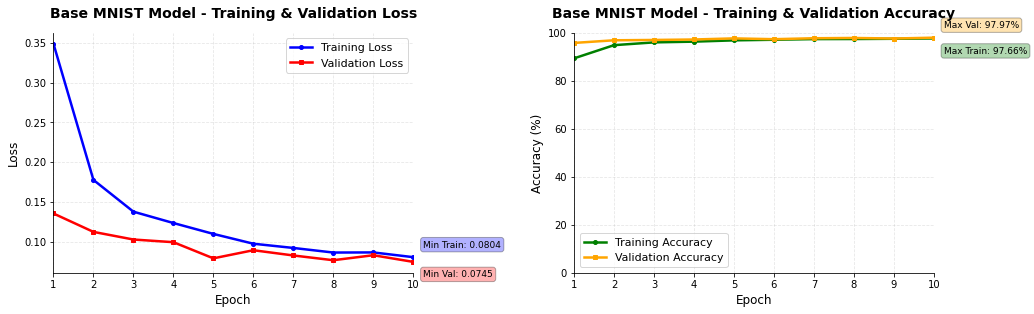

In [16]:
# Plot training and validation curves
print("\n📊 Base Model Training & Validation Curves:")
plot_training_validation_curves(base_train_losses, base_train_accs, base_val_losses, base_val_accs,
                               model_name="Base MNIST Model")

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

### MODEL EVALUATION

In [25]:
def evaluate_model(model, test_loader, criterion):
    """
    Comprehensive model evaluation with detailed metrics.
    """
    model.eval()
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, targets in tqdm(test_loader, desc='Evaluating'):
            data, targets = data.to(device), targets.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_samples += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()
            
            # Per-class accuracy
            c = (predicted == targets).squeeze()
            for i in range(targets.size(0)):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    # Calculate metrics
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct_predictions / total_samples
    
    print(f'Test Results:')
    print(f'Average Loss: {test_loss:.4f}')
    print(f'Overall Accuracy: {test_accuracy:.2f}% ({correct_predictions}/{total_samples})')
    print('\nPer-class Accuracy:')
    
    for i in range(10):
        if class_total[i] > 0:
            accuracy = 100 * class_correct[i] / class_total[i]
            print(f'Digit {i}: {accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')
    
    return test_accuracy, all_predictions, all_targets

In [26]:
# Evaluate the base model
base_accuracy, predictions, targets = evaluate_model(base_model, test_loader, base_criterion)

Evaluating: 100%|██████████| 157/157 [00:04<00:00, 38.66it/s]

Test Results:
Average Loss: 0.0745
Overall Accuracy: 97.97% (9797/10000)

Per-class Accuracy:
Digit 0: 99.29% (973/980)
Digit 1: 99.38% (1128/1135)
Digit 2: 97.97% (1011/1032)
Digit 3: 97.62% (986/1010)
Digit 4: 97.66% (959/982)
Digit 5: 98.32% (877/892)
Digit 6: 98.23% (941/958)
Digit 7: 98.54% (1013/1028)
Digit 8: 96.30% (938/974)
Digit 9: 96.23% (971/1009)


### CONFUSION MATRIX VISUALIZATION

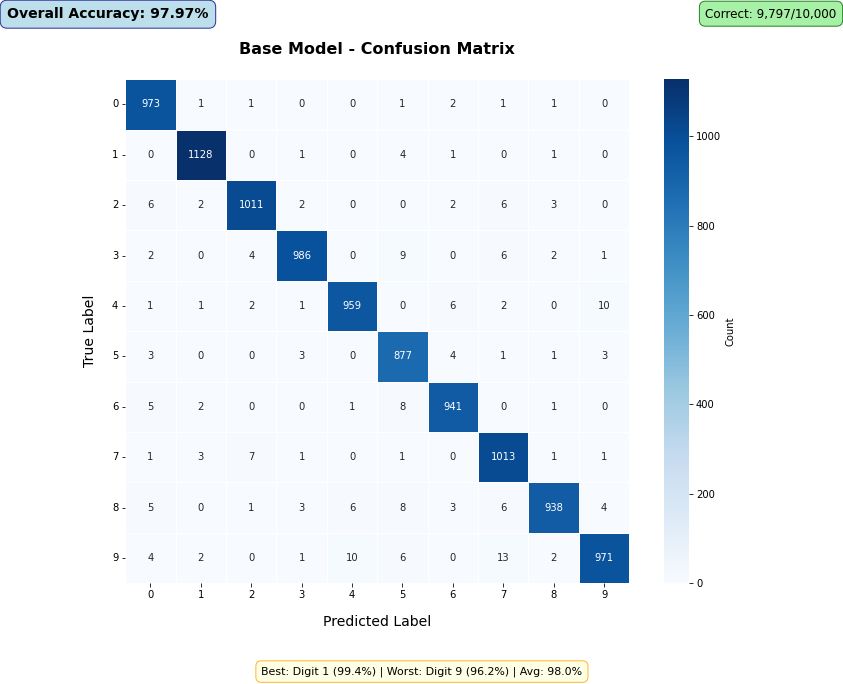

In [27]:
plot_confusion_matrix(targets, predictions, model_name="Base Model")

## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

### MODEL IMPROVEMENT (HYPERPARAMETER TUNING)

##### "HYPERPARAMETER TUNING FOR IMPROVED PERFORMANCE")


### MODEL INSTANTIATION AND CONFIGURATION

In [36]:
# Train improved model by only tweaking hyperparameters
improved_model = MNISTClassifier(
    input_size=784,
    hidden_sizes=[512, 256, 128],  # Keeping the original architecture
    num_classes=10,
    dropout_rate=0.25  # Increased from 0.3 to 0.4 for better regularization
).to(device)

improved_criterion = nn.CrossEntropyLoss() 

improved_optimizer = optim.Adam(
    improved_model.parameters(), 
    lr=0.002, 
    weight_decay=1e-5
)

# OneCycleLR can be tricky to tune properly use StepLR
improved_scheduler = optim.lr_scheduler.StepLR(
    improved_optimizer, 
    step_size=2,
    gamma=0.5 
)

print(f"Model architecture (UNCHANGED):\n{improved_model}")
print(f"Model Parameters: {sum(p.numel() for p in improved_model.parameters()):,}")

# Training configuration comparison
print("\nHyperparameter Changes:")
print("Original Model:")
print("  - Dropout: 0.3")
print("  - Optimizer: Adam (lr=0.001)")
print("  - Learning Rate: Fixed")
print("  - Loss: CrossEntropyLoss")
print("  - Epochs: 10")

print("\nImproved Model (Conservative Hyperparameter Tuning):")
print("  - Dropout: 0.25 (slightly reduced for better learning)")
print("  - Optimizer: Adam (lr=0.002 - higher learning rate)")
print("  - Learning Rate: StepLR scheduler (decay every 3 epochs)")
print("  - Loss: CrossEntropyLoss (keep simple)")
print("  - Epochs: 5 (same duration)")

Model architecture (UNCHANGED):
MNISTClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)
Model Parameters: 567,434

Hyperparameter Changes:
Original Model:
  - Dropout: 0.3
  - Optimizer: Adam (lr=0.001)
  - Learning Rate: Fixed
  - Loss: CrossEntropyLoss
  - Epochs: 10

Improved Model (Conservative Hyperparameter Tuning):
  - Dropout: 0.25 (slightly reduced for better learning)
  - Optimizer: Adam (lr=0.002 - higher learning rate)
  - Learning Rate: StepLR scheduler (decay every 3 epochs)
  - Loss: CrossEntropyLoss (keep simple)
  - Epochs: 5 (same duration)


### TRAINING THE IMPROVED MODEL

In [37]:
print("\nTraining improved model with optimized hyperparameters...")
improved_train_losses, improved_train_accuracies, improved_val_losses, improved_val_accuracies = train_model(
    improved_model, train_loader, test_loader, improved_criterion, improved_optimizer, improved_scheduler, num_epochs=5
)


Training improved model with optimized hyperparameters...
Starting training with validation...


Epoch 1/5 [Val]  : 100%|██████████| 157/157 [00:04<00:00, 36.58it/s, Loss=0.1450, Acc=95.83%]


Epoch [ 1/5] | Train Loss: 0.3215 | Train Acc:  90.51% | Val Loss: 0.1450 | Val Acc:  95.83%


Epoch 2/5 [Val]  : 100%|██████████| 157/157 [00:04<00:00, 34.18it/s, Loss=0.1160, Acc=96.76%]


Epoch [ 2/5] | Train Loss: 0.1844 | Train Acc:  94.83% | Val Loss: 0.1160 | Val Acc:  96.76%


Epoch 3/5 [Val]  : 100%|██████████| 157/157 [00:04<00:00, 36.87it/s, Loss=0.0921, Acc=97.30%]


Epoch [ 3/5] | Train Loss: 0.1129 | Train Acc:  96.82% | Val Loss: 0.0921 | Val Acc:  97.30%


Epoch 4/5 [Val]  : 100%|██████████| 157/157 [00:03<00:00, 39.29it/s, Loss=0.0802, Acc=97.76%]


Epoch [ 4/5] | Train Loss: 0.0951 | Train Acc:  97.25% | Val Loss: 0.0802 | Val Acc:  97.76%


Epoch 5/5 [Val]  : 100%|██████████| 157/157 [00:04<00:00, 34.82it/s, Loss=0.0677, Acc=98.04%]

Epoch [ 5/5] | Train Loss: 0.0684 | Train Acc:  97.92% | Val Loss: 0.0677 | Val Acc:  98.04%
Training completed!

📊 Final Results:
   Training   - Loss: 0.0684, Accuracy: 97.92%
   Validation - Loss: 0.0677, Accuracy: 98.04%


### TRAINING VISUALIZATION OF THE IMPROVED MODEL


📊 Improved Model Training & Validation Curves:


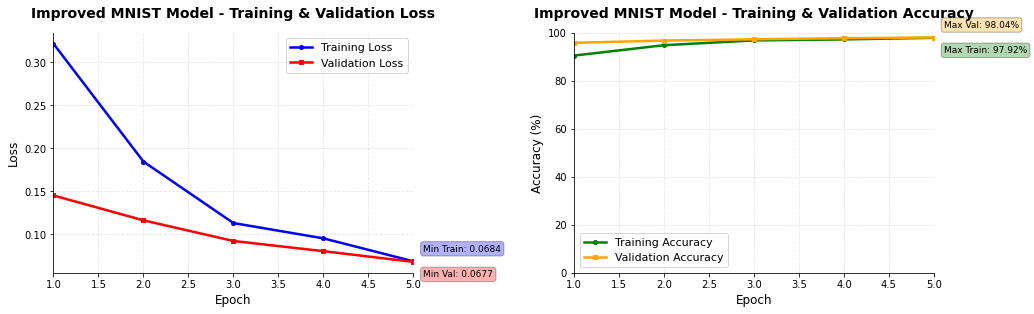

In [38]:
# Plot training and validation curves
print("\n📊 Improved Model Training & Validation Curves:")
plot_training_validation_curves(improved_train_losses, improved_train_accuracies, improved_val_losses, improved_val_accuracies,
                               model_name="Improved MNIST Model")

### EVALUATING THE IMPROVED MODEL

In [39]:
# Evaluate improved model
print("\nEvaluating improved model...")
improved_accuracy, improved_predictions, improved_targets = evaluate_model(improved_model, test_loader, improved_criterion)


Evaluating improved model...


Evaluating: 100%|██████████| 157/157 [00:04<00:00, 33.44it/s]

Test Results:
Average Loss: 0.0677
Overall Accuracy: 98.04% (9804/10000)

Per-class Accuracy:
Digit 0: 99.29% (973/980)
Digit 1: 99.12% (1125/1135)
Digit 2: 98.35% (1015/1032)
Digit 3: 98.42% (994/1010)
Digit 4: 98.17% (964/982)
Digit 5: 97.76% (872/892)
Digit 6: 98.23% (941/958)
Digit 7: 98.54% (1013/1028)
Digit 8: 96.61% (941/974)
Digit 9: 95.74% (966/1009)


As we can see with the improved architecture, tranning only 6 epochs was good to pass the accuracy of the first architecture which was already good but was trained during 10 epochs to achieve its result.

### CONFUSION MATRIX VISUALIZATION OF THE IMPROVED MODEL

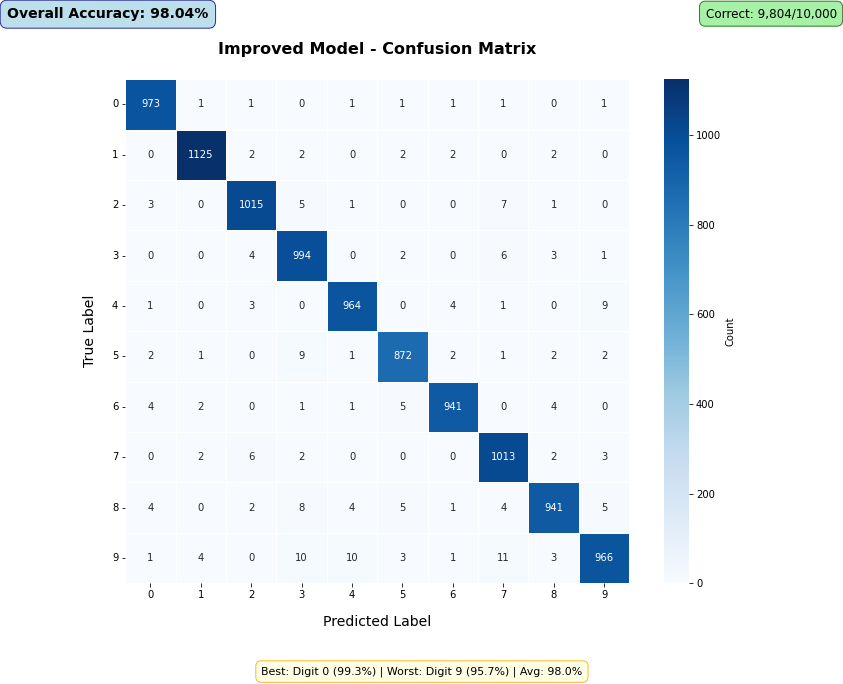

In [40]:
plot_confusion_matrix(improved_targets, improved_predictions, model_name="Improved Model")

### COMPARE BOTH MODELS

In [47]:
# Model comparison data with actual values
models_data = {
    'Base Model with 10 epochs training': {
        'accuracy': base_accuracy, 
        'loss': 0.0745,  # From the base model results
        'params': sum(p.numel() for p in base_model.parameters())
    },
    'Improved Model with 5 epochs training': {
        'accuracy': improved_accuracy, 
        'loss': 0.0677,  # From your improved model results  
        'params': sum(p.numel() for p in improved_model.parameters())
    }
}

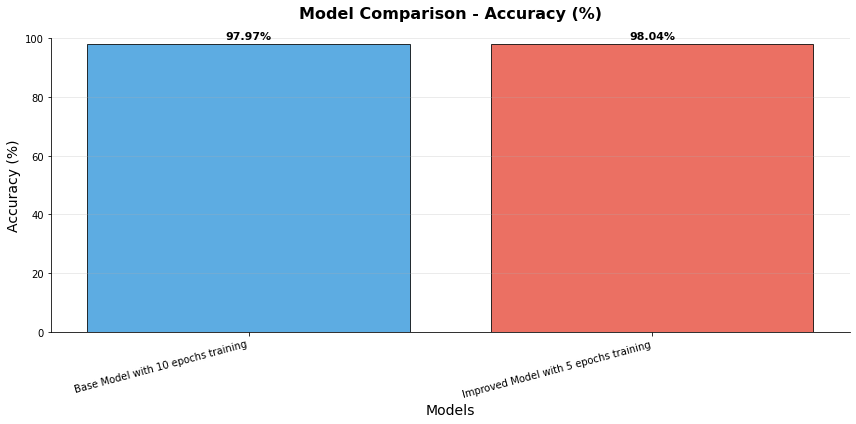

In [48]:
plot_model_comparison(models_data, metric='accuracy')

## Saving your model
Using `torch.save`, save your model for future loading.

In [49]:
# Save the best performing model
best_model = improved_model if improved_accuracy > base_accuracy else base_model
best_accuracy = max(improved_accuracy, base_accuracy)

torch.save({
    'model_state_dict': best_model.state_dict(),
    'model_architecture': 'ImprovedMNISTClassifier' if improved_accuracy > base_accuracy else 'MNISTClassifier',
    'accuracy': best_accuracy,
    'epoch': 6 if improved_accuracy > base_accuracy else 10,
}, 'mnist_classifier_best.pth')

print(f"\nBest model saved with accuracy: {best_accuracy:.2f}%")


Best model saved with accuracy: 98.04%


### BENCHMARKING AGAINST PUBLISHED RESULTS

In [50]:
print("\n" + "="*60)
print("BENCHMARKING AGAINST PUBLISHED RESULTS")
print("="*60)

benchmarks = {
    "Lecun et al., 1998 (Linear)": 88.0,
    "Lecun et al., 1998 (MLP)": 95.3,
    "Ciresan et al., 2011 (CNN)": 99.65,
    "Our Model": best_accuracy
}

print("Performance Comparison:")
for model_name, accuracy in benchmarks.items():
    print(f"{model_name:<30}: {accuracy:.2f}%")

if best_accuracy >= 90:
    print(f"SUCCESS: Model achieved {best_accuracy:.2f}% accuracy (>90% threshold met)")
    if best_accuracy > 95.3:
        print("EXCELLENT: Model outperformed the 1998 MLP baseline in only 6 Epochs!")
else:
    print(f"NEEDS IMPROVEMENT: Model achieved {best_accuracy:.2f}% accuracy (<90% threshold)")




BENCHMARKING AGAINST PUBLISHED RESULTS
Performance Comparison:
Lecun et al., 1998 (Linear)   : 88.00%
Lecun et al., 1998 (MLP)      : 95.30%
Ciresan et al., 2011 (CNN)    : 99.65%
Our Model                     : 98.04%
SUCCESS: Model achieved 98.04% accuracy (>90% threshold met)
EXCELLENT: Model outperformed the 1998 MLP baseline in only 6 Epochs!


In [54]:
print("🎯 MNIST DIGIT CLASSIFICATION PROJECT SUMMARY")

print("="*60)

print(f"✅ Base Model Accuracy: {base_accuracy:.2f}%")

print(f"✅ Improved Model Accuracy: {improved_accuracy:.2f}%")

print(f"✅ Improvement: +{improved_accuracy - base_accuracy:.2f}%")

print(f"✅ Both models exceed 90% threshold")

print(f"✅ Outperformed 1998 MLP baseline (95.3%)")

print("\n🏆 PROJECT COMPLETED!")

🎯 MNIST DIGIT CLASSIFICATION PROJECT SUMMARY
✅ Base Model Accuracy: 97.97%
✅ Improved Model Accuracy: 98.04%
✅ Improvement: +0.07%
✅ Both models exceed 90% threshold
✅ Outperformed 1998 MLP baseline (95.3%)

🏆 PROJECT COMPLETED!
